# Introduction
In this project, I will do a sentiment analysis with Random Forest Classifier for a supervised dataset including some tweets and detailed information about regarding tweets. Data can be found [here](https://www.kaggle.com/crowdflower/twitter-airline-sentiment).

### Table of contents
- [Reading and cleaning the data](#Reading-and-cleaning-the-data)
- [Feature engineering](#Feature-engineering)
- [Preprocessing](#Preprocessing)
- [Model selection and evaluation](#Model-selection-and-evaluation)
- [Conclusion](#Conclusion)

## Reading and cleaning the data

In [1]:
# Import libraries and modules
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Read the data into a pandas dataframe
data = pd.read_csv("data/Tweets.csv", sep=",")
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
# Create a new dataframe for only two columns
tweets = data.loc[:,['airline_sentiment','text']]
tweets.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [5]:
import re
import string

# Stopwords in English language
stopword = nltk.corpus.stopwords.words('english')

# Lemmatizer
wn = nltk.WordNetLemmatizer()

# Function to clean and tokenize the data
def clean_tokenize_text(text):
    # Remove mentions starting with @
    text = re.sub('@\w+\s', '', text)
    
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    
    text = text.lower()
    
    # Tokenize the text
    tokens = re.split('\W+', text)
    
    # Remove stopwords
    text = [word for word in tokens if word not in stopword]
    
    # Lemmatize the words
    text = [wn.lemmatize(word) for word in text]
    
    # Return text
    return text


# Apply the function to text column
tweets['text'] = tweets['text'].apply(lambda x: clean_tokenize_text(x))

# Display first five rows
tweets.head()

,label,body,text_len
0,neutral,[said],32
1,positive,"[plus, youve, added, commercial, experience, t...",64
2,neutral,"[didnt, today, must, mean, need, take, another...",60
3,negative,"[really, aggressive, blast, obnoxious, enterta...",110
4,negative,"[really, big, bad, thing]",46



## Feature Engineering


In [4]:
# Create a new column for word count in a tweet
tweets['text_len'] = tweets['text'].apply(lambda x: len(x) - x.count(' '))

# Rename the columns
tweets.columns=['label','body','text_len']

tweets.head()

,airline_sentiment,text,text_len
0,neutral,@VirginAmerica What @dhepburn said.,32
1,positive,@VirginAmerica plus you've added commercials t...,64
2,neutral,@VirginAmerica I didn't today... Must mean I n...,60
3,negative,@VirginAmerica it's really aggressive to blast...,110
4,negative,@VirginAmerica and it's a really big bad thing...,46


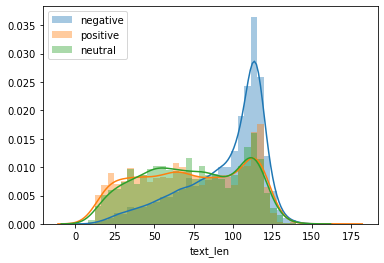

In [6]:
# Import libraries
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

# Create a density plot for word counts for each label
bins = np.linspace(0,140,35)
sns.distplot(tweets[tweets['label']=='negative']['text_len'], bins, label='negative')
sns.distplot(tweets[tweets['label']=='positive']['text_len'], bins, label='positive')
sns.distplot(tweets[tweets['label']=='neutral']['text_len'], bins, label='neutral')
plt.legend(loc='upper left')
plt.show()

## Preprocessing

### Train/Test set split

In [7]:
# Create a new dataframe for 'airline_sentiment' and 'text' columns
data = data.loc[:,['airline_sentiment','text']]

# Rename the columns
data.columns = ['label', 'body']

# Create a column for word counts in each tweet except for white spaces
data['text_len'] = data['body'].apply(lambda x: len(x) - x.count(" "))

# Import module
from sklearn.model_selection import train_test_split

# Split train and test sets
X_train, X_test, y_train, y_test = train_test_split(data[['body', 'text_len']], data['label'], test_size=0.2)

### Vectorizing the text

In [8]:
# Vectorize the data with applying the cleaning function above
tfidf_vect = TfidfVectorizer(analyzer=clean_tokenize_text)

# Fit the train set
tfidf_vect_fit = tfidf_vect.fit(X_train['body'])

# Transform train and test sets
tfidf_train = tfidf_vect_fit.transform(X_train['body'])
tfidf_test = tfidf_vect_fit.transform(X_test['body'])

# Create new dataframe for train and test sets including 'text_len' column
X_train_vect = pd.concat([X_train['text_len'].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test['text_len'].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

# Display first 5 rows of vectorized train set
X_train_vect.head()


,text_len,0,1,2,3,4,5,6,7,8,...,13034,13035,13036,13037,13038,13039,13040,13041,13042,13043
0,93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
# Get the first 10 feature names in whole dataset
print(tfidf_vect.get_feature_names()[0:10])

['', '0', '00', '0011', '006', '0162389030167', '0162424965446', '0162431184663', '0167560070877', '0214']


## Model evaluation

### Random Forest Classifier

In [14]:
# Import random forest classifier
from sklearn.ensemble import RandomForestClassifier

# Import cross validation score evaluation
from sklearn.model_selection import cross_val_score

### Grid Search with Random Forest Classifier

In [51]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

In [55]:
# Define parameters
param = {
    'n_estimators': [10, 50, 100], 
    'max_depth': [10, 20, 30, None],
    }

# Create a model
clf = GridSearchCV(rf_class, param,cv=5, n_jobs=-1)

# Fit the vectorized train set
rf_model = clf.fit(X_train_vect, y_train)

# Create a dataframe for the cross validation results
pd.DataFrame(rf_model.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,110.023747,14.291431,2.619199,1.408736,None,100,"{'max_depth': None, 'n_estimators': 100}",0.756295,0.755015,0.748506,0.745517,0.743382,0.749743,0.005110,1
10,59.696254,6.893535,3.379891,0.497844,None,50,"{'max_depth': None, 'n_estimators': 50}",0.749040,0.749040,0.749787,0.738685,0.738258,0.744962,0.005308,2
9,31.586190,1.568620,2.304497,0.451836,None,10,"{'max_depth': None, 'n_estimators': 10}",0.725992,0.741784,0.731426,0.727156,0.726302,0.730532,0.005955,3
6,16.819460,2.625951,2.025805,0.373855,30,10,"{'max_depth': 30, 'n_estimators': 10}",0.671788,0.664533,0.666097,0.672929,0.649445,0.664958,0.008394,4
7,26.079729,4.850577,1.565472,1.225647,30,50,"{'max_depth': 30, 'n_estimators': 50}",0.650875,0.655570,0.642613,0.649445,0.657131,0.651127,0.005122,5


### Finalizing the model

In [56]:
# Create a model with defined parameters
rf_class = RandomForestClassifier(n_estimators=100, max_depth=None, n_jobs=-1)

# Fit the vectorized train set to the model
rf_model = rf_class.fit(X_train_vect, y_train)

In [57]:
# Display feature importances with feature names
sorted(zip(rf_model.feature_importances_, X_train_vect.columns), reverse=True)[0:10]

[(0.04952090098112615, 'text_len'),
 (0.02914409168530371, 11562),
 (0.027716398076613177, 11554),
 (0.009671612202788319, 0),
 (0.009427500215855781, 5517),
 (0.009065091486993184, 5921),
 (0.008575407936432296, 4981),
 (0.006458956945190879, 7894),
 (0.005727318614915038, 3715),
 (0.005568458777418891, 2340)]

In [58]:
from sklearn.metrics import precision_recall_fscore_support as score

# Predict the vectorized test set
y_pred = rf_model.predict(X_test_vect)

# Get scores
precision, recall, fscore, support = score(y_test, y_pred, average='weighted')

In [59]:
# Print the scores
print('Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3),
                                                        round(recall, 3),
                                                        round((y_pred==y_test).sum() / len(y_pred),3)))

Precision: 0.752 / Recall: 0.759 / Accuracy: 0.759


In [61]:
from sklearn.metrics import classification_report

# Create a classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.77      0.95      0.85      1821
     neutral       0.68      0.40      0.50       634
    positive       0.78      0.52      0.62       473

    accuracy                           0.76      2928
   macro avg       0.74      0.62      0.66      2928
weighted avg       0.75      0.76      0.74      2928

